# Предсказание цены на недвижимость

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

In [274]:
import warnings
warnings.filterwarnings('ignore')

**Описание датасета**

Статистические данные о недвижимости.   

* **Id** - идентификационный номер недвижимости
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** -  год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена недвижимости

In [313]:
train_df = pd.read_csv('train.csv', encoding='utf-8')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [314]:
test_df = pd.read_csv('test.csv', encoding='utf-8')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


**Удаление дубликатов и определение меток пропущенных значений**

In [222]:
def drop_duplicates(df):
    df.drop_duplicates(keep=False)
    return df.shape

In [223]:
def nominal_variables_count(df):
    for key, value in df.iteritems():
        if df.dtypes[key] == 'object':
            print(df[key].value_counts())

In [224]:
def numerical_unique_values(df):
    for key, value in df.iteritems():
        if df.dtypes[key] == 'float64' or df.dtypes[key] == 'int64':
            print(key, df[key].unique())

In [225]:
drop_duplicates(train_df)

(10000, 20)

In [226]:
drop_duplicates(test_df)

(5000, 19)

In [227]:
nominal_variables_count(train_df)

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [228]:
nominal_variables_count(test_df)

B    4952
A      48
Name: Ecology_2, dtype: int64
B    4851
A     149
Name: Ecology_3, dtype: int64
B    4588
A     412
Name: Shops_2, dtype: int64


In [229]:
numerical_unique_values(train_df)

Id [14038 15053  4765 ...  5123  5400  6306]
DistrictId [ 35  41  53  58  99  59 154  74   1  23  28  31  13  57  27  85  34  19
   0  48  54 150  11  50  61  44  90 200  43 177 101  38  21 103  98 170
  94   5  88  47   6  52  62  77  79   9 156  69 108  96 169  18 148 128
  10 144 120  39   7  84 123 159  70 129   3  95  78  45  15 121  49  25
   2 127  56 109  46  17 119  80  86  83 137  91  92 118 187  36 106 161
  22  63 167 113  66  29  37  20   8 181  40  93  30  81 107 130 100  12
 125  67  26  89  24 111 138  64 124 183  55 157 151  33  87 126 155 164
 105 110 132  71  73 189  75 122 163 141  76 115 139 143 201 165 190 193
 174  60 114 172 134 117 149 153 131 145  82 160  42  32 133 208 171 176
 173 147  97 142 195 180 196 112  72 175   4 186 146 191 168 192  14 199
 136 162 179 188 135 140  16  51 178 104  68 152 194 116 207 185  65 102
 166 182 202 184 205 209 158]
Rooms [ 2.  3.  1.  4. 10.  0.  5. 19.  6.]
Square [47.98156124 65.68363987 44.94795276 ... 47.93900767 43.6025

In [230]:
numerical_unique_values(test_df)

Id [  725 15856  5480 ...  5783  4780 12504]
DistrictId [ 58  74 190  47  27  53  23  32  96   6  61   3  46  41 167  90  57   1
  11  62  85  31  15  83  80 205   0  52  21 123  45 101  34 212  67  72
  29  39 141 113  30 161  48  18 120  75  99 163  37   8  24 164   7  44
 125  84   9  69  87  28  66 169  12 108  71 129 111  76  56 193  63  33
  49  77  59  13 187 180 128  20  26  36  79  51  70   5  98  86  55 119
 116   2  78  94 151  14 156  54  82  95  22 105 176 121 114  88  93 118
 126 127  17  81  25 153  60 100 148 112  64 138 115 110  35 175  97 149
 122  91 179 171 188 155  16 152  10 124 159 182 139 104  68 157  42  89
 103 160 106 142 177 191  19 107  38 178 130 183 170 189 134 102 194 166
  73 132 144 109 208 210 137 147 145  92 140 143 131  43 206 168 181 184
 172 146 185   4 135 150 173 204 203 211  65  40 196 136 209 165 154 192
 198 200 186]
Rooms [ 2.  1.  3.  4.  5.  6.  0. 17.]
Square [49.88264339 69.26318347 13.5978185  ... 77.84217793 81.305222
 60.5556927 ]
Lif

Метки пропущенных значений NaN.

**Подготовка датасета**

In [315]:
def prepare_values(df):
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['Square'] - df['KitchenSquare']
    df.loc[df['Rooms'] == 0, 'Rooms'] = df['Rooms'].mode()[0]
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].mode()[0]
    df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['Healthcare_1'].median()

In [316]:
prepare_values(train_df)

In [317]:
prepare_values(test_df)

**Обработка выбросов**

Text(0, 0.5, 'Price')

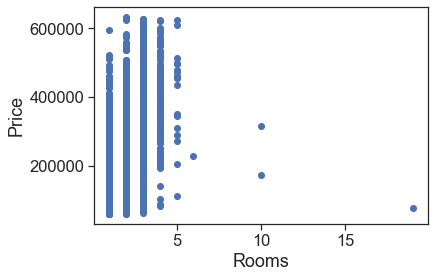

In [318]:
plt.scatter(train_df['Rooms'], train_df['Price']);
plt.xlabel('Rooms')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

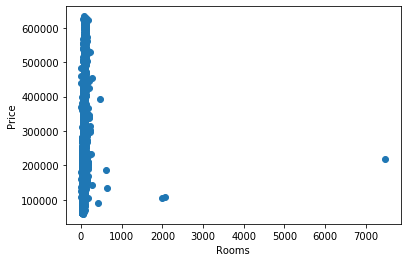

In [235]:
plt.scatter(train_df['Square'], train_df['Price']);
plt.xlabel('Rooms')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

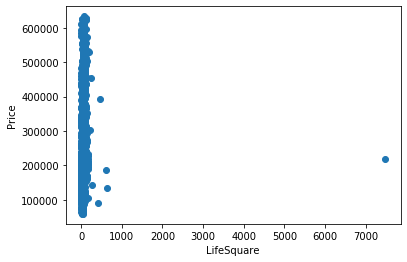

In [236]:
plt.scatter(train_df['LifeSquare'], train_df['Price']);
plt.xlabel('LifeSquare')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

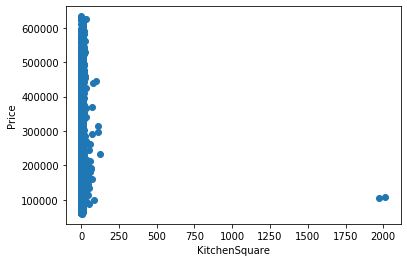

In [237]:
plt.scatter(train_df['KitchenSquare'], train_df['Price']);
plt.xlabel('KitchenSquare')
plt.ylabel('Price')

In [319]:
def replace_deviations(df):
    df.loc[(df['Rooms'] > 5), 'Rooms'] = df['Rooms'].mode()[0]
    df.loc[df['Square'] > 1500, 'Square'] = df['Square'].median()
    df.loc[df['LifeSquare'] > 6000, 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['KitchenSquare'] > 1500, 'KitchenSquare'] = df['KitchenSquare'].median()
    df.loc[df['KitchenSquare'] == 0, 'KitchenSquare'] = df['KitchenSquare'].median()

In [320]:
replace_deviations(train_df)

In [321]:
replace_deviations(test_df)

**Feature enginering**

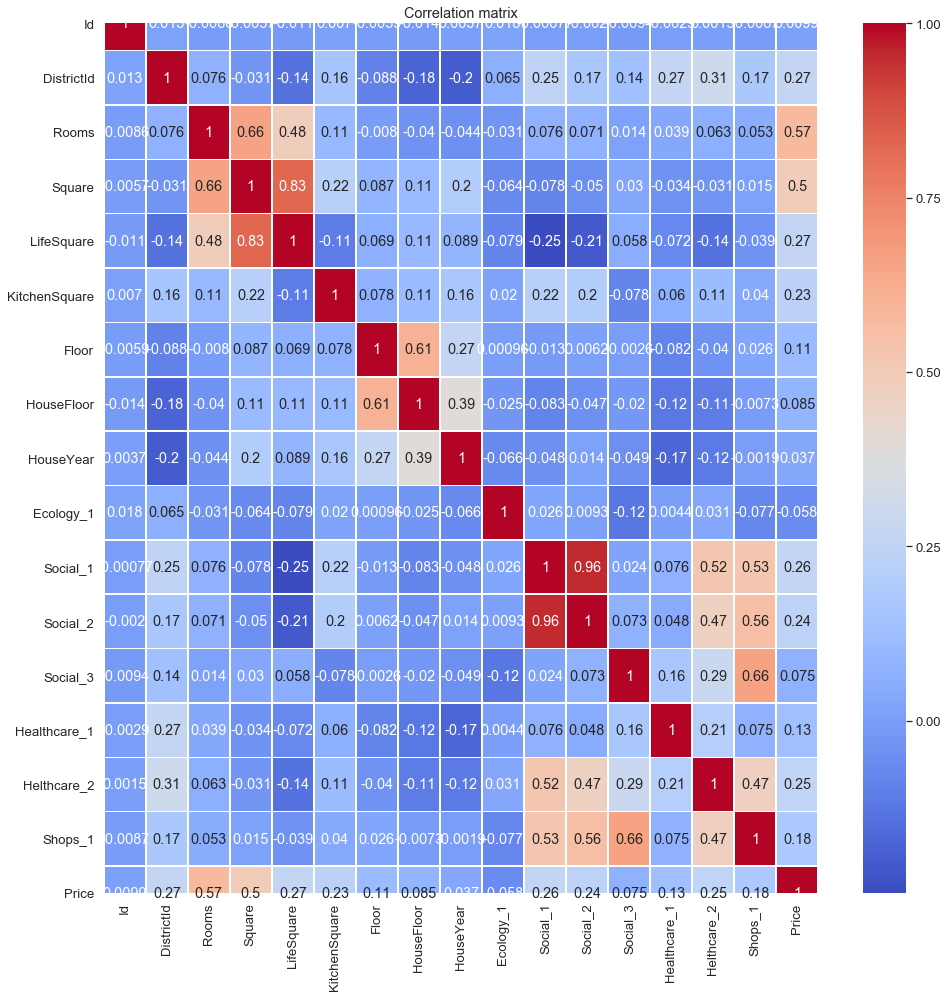

In [241]:
plt.figure(figsize = (16,16))

sns.set(font_scale=1.2)
sns.heatmap(train_df.corr(), 
            annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix');

Создам новые признаки

* **HouseAge** - возраст дома
* **PricePerSquare** - цена за квадратный метр
* **RoomSquare** - жилая площадь на комнату
* **PricePerRoom** - цена одной комнаты
* **LifeSquarePerSquare** - доля жилой площади в общей площади
* **KitchenSquareShare** - доля площади кухни в общей площади
* **KitchenSquarePerLifeSquare** - доля площади кухни в жилой площади

А также соотвествующие им ценовые признаки

In [322]:
def get_new_variables(df):
    df['HouseAge'] = pd.DataFrame(2020 - df['HouseYear'])
    df['PricePerSquare'] = df['Price'] / df['Square']
    df['RoomSquare'] = df['LifeSquare'] / df['Rooms']
    df['PricePerRoom'] = df['Price'] / df['Rooms']
    df['LifeSquarePerSquare'] = df['LifeSquare'] / df['Square']
    df['KitchenSquareShare'] = df['KitchenSquare'] / df['Square']
    df['KitchenSquarePerLifeSquare'] = df['KitchenSquare'] / df['LifeSquare']
    df['KitchenSquareSharePrice'] = df['Price'] / df['KitchenSquareShare']
    df['KitchenSquarePerLifeSquarePrice'] = df['Price'] * df['KitchenSquarePerLifeSquare']
    df['PricePerLifeSquare'] = df['Price'] / df['LifeSquare']
    df['PricePerKitchenSquare'] = df['Price'] / df['KitchenSquare']
    df['UsefulSquare'] = (df['LifeSquare'] + df['KitchenSquare'])/df['Square']
    df['PricePerUsefulSquare'] = df['Price'] / df['UsefulSquare']
    df['RoomSquarePrice'] = df['Price'] / df['RoomSquare']
    df['TotalRoomSquare'] = df['Square'] / df['Rooms']
    df['KitchenRoomSquare'] = df['KitchenSquare'] / df['Rooms']
    df['TotalRoomSquarePrice'] = df['Price'] / df['TotalRoomSquare']
    df['KitchenRoomSquarePrice'] = df['Price'] / df['KitchenRoomSquare']
    return df.head()

In [323]:
get_new_variables(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,KitchenSquarePerLifeSquarePrice,PricePerLifeSquare,PricePerKitchenSquare,UsefulSquare,PricePerUsefulSquare,RoomSquarePrice,TotalRoomSquare,KitchenRoomSquare,TotalRoomSquarePrice,KitchenRoomSquarePrice
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,37693.543020,6282.257170,30827.821788,0.738674,250403.876005,12564.514340,23.990781,3.000000,7709.917142,61655.643577
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,59927.665818,7490.958227,37501.181258,0.731530,410112.389032,22472.874682,21.894547,2.666667,13702.473735,112503.543774
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,45399.447917,7566.574653,36820.984754,0.783075,282126.167784,15133.149306,22.473976,3.000000,9830.299043,73641.969508
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,29973.463372,3330.384819,19512.914135,1.157040,151780.654410,6660.769638,26.676491,4.500000,6583.183273,39025.828270
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,44228.559975,6318.365711,21460.933092,0.776212,193538.077064,6318.365711,39.649192,7.000000,3788.892642,21460.933092


Ценовые признаки в тестовом датасете вычислить невозможно. Нужно обработать переменную DistrictId и присоединить по ней данные 
из тренировочного датасета.

In [324]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

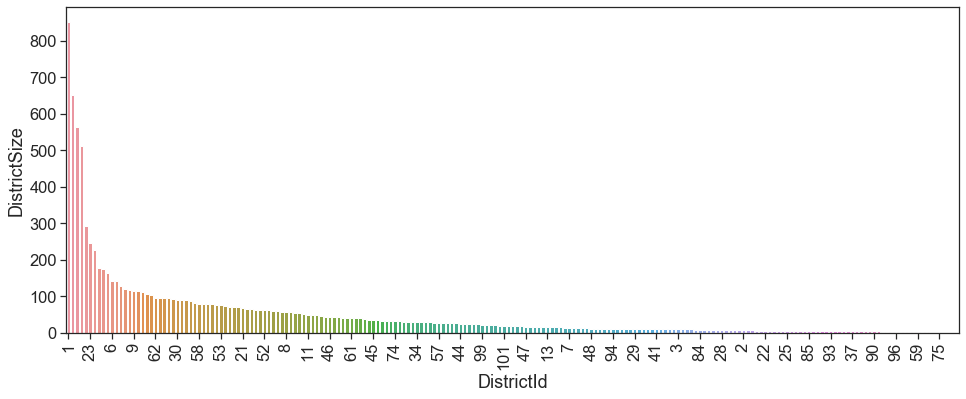

In [250]:
sns.set(style='ticks', font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId',
               data=district_size,
               order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']);
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [325]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

In [326]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                                DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size

,DistrictId,DistrictSize
0,1,652
1,6,511
2,8,142
3,9,294
4,11,129
5,21,165
6,23,565
7,27,851
8,30,228
9,34,111


In [327]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [328]:
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)

Сгруппирую цену и новые признаки по району.

In [329]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerRoom':'median'})\
                        .rename(columns={'PricePerRoom':'PricePerRoomByDistrict'})
train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [330]:
square_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerSquare':'median'})\
                        .rename(columns={'PricePerSquare':'PricePerSquareByDistrict'})
train_df = train_df.merge(square_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [331]:
kitchen_share_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'KitchenSquareSharePrice':'median'})\
                        .rename(columns={'KitchenSquareSharePrice':'KitchenSquareSharePriceByDistrict'})
train_df = train_df.merge(kitchen_share_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [332]:
kitchen_perls_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'KitchenSquarePerLifeSquarePrice':'median'})\
                        .rename(columns={'KitchenSquarePerLifeSquarePrice':'KitchenSquarePerLifeSquarePriceByDistrict'})
train_df = train_df.merge(kitchen_perls_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [333]:
lifesquare_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerLifeSquare':'median'})\
                        .rename(columns={'PricePerLifeSquare':'PricePerLifeSquareByDistrict'})
train_df = train_df.merge(lifesquare_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [334]:
kitchensquare_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerKitchenSquare':'median'})\
                        .rename(columns={'PricePerKitchenSquare':'PricePerKitchenSquareByDistrict'})
train_df = train_df.merge(kitchensquare_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [335]:
usefulsquare_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerUsefulSquare':'median'})\
                        .rename(columns={'PricePerUsefulSquare':'PricePerUsefulSquareByDistrict'})
train_df = train_df.merge(usefulsquare_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [336]:
roomsquare_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'RoomSquarePrice':'median'})\
                        .rename(columns={'RoomSquarePrice':'RoomSquarePriceByDistrict'})
train_df = train_df.merge(roomsquare_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [337]:
total_roomsquare_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'TotalRoomSquarePrice':'median'})\
                        .rename(columns={'TotalRoomSquarePrice':'TotalRoomSquarePriceByDistrict'})
train_df = train_df.merge(total_roomsquare_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [338]:
kitchenroom_price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'KitchenRoomSquarePrice':'median'})\
                        .rename(columns={'KitchenRoomSquarePrice':'KitchenRoomSquarePriceByDistrict'})
train_df = train_df.merge(kitchenroom_price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)

In [339]:
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(square_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(kitchen_share_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(kitchen_perls_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(lifesquare_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(kitchensquare_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(usefulsquare_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(roomsquare_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(total_roomsquare_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df = test_df.merge(kitchenroom_price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)
test_df['LifeSquarePerSquare'] = test_df['LifeSquare'] / test_df['Square']
test_df['KitchenSquareShare'] = test_df['KitchenSquare'] / test_df['Square']
test_df['KitchenSquarePerLifeSquare'] = test_df['KitchenSquare'] / test_df['LifeSquare']
test_df['UsefulSquare'] = (test_df['LifeSquare'] + test_df['KitchenSquare'])/test_df['Square']
test_df['TotalRoomSquare'] = test_df['Square'] / test_df['Rooms']
test_df['KitchenRoomSquare'] = test_df['KitchenSquare'] / test_df['Rooms']

Получу дамми переменные

In [340]:
def get_dummies(df):
    feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']
    df[feature_bin_names] = df[feature_bin_names].replace({'A':0, 'B':1})
    return df.head()

In [341]:
get_dummies(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,PricePerRoomByDistrict,PricePerSquareByDistrict,KitchenSquareSharePriceByDistrict,KitchenSquarePerLifeSquarePriceByDistrict,PricePerLifeSquareByDistrict,PricePerKitchenSquareByDistrict,PricePerUsefulSquareByDistrict,RoomSquarePriceByDistrict,TotalRoomSquarePriceByDistrict,KitchenRoomSquarePriceByDistrict
0,14038,999,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,129339.268164,4491.570378,1.654164e+06,52823.368641,7260.736399,32362.565852,283160.414019,13042.524599,8359.555280,64981.638037
1,15053,999,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,129339.268164,4491.570378,1.654164e+06,52823.368641,7260.736399,32362.565852,283160.414019,13042.524599,8359.555280,64981.638037
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,138669.199925,4845.919064,2.048088e+06,51163.490979,6900.415219,37175.441994,289882.903940,11998.984014,8986.992619,82671.459029
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,105638.516748,2949.975415,1.873453e+06,18800.568109,3252.381904,29451.448620,168158.738317,6045.861014,4161.837095,61739.842948
4,10783,999,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,129339.268164,4491.570378,1.654164e+06,52823.368641,7260.736399,32362.565852,283160.414019,13042.524599,8359.555280,64981.638037


In [342]:
get_dummies(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,PricePerUsefulSquareByDistrict,RoomSquarePriceByDistrict,TotalRoomSquarePriceByDistrict,KitchenRoomSquarePriceByDistrict,LifeSquarePerSquare,KitchenSquareShare,KitchenSquarePerLifeSquare,UsefulSquare,TotalRoomSquare,KitchenRoomSquare
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,168158.738317,6045.861014,4161.837095,61739.842948,0.670229,0.120282,0.179465,0.790511,24.941322,3.0
1,15856,74,2.0,69.263183,68.263183,1.0,6,1.0,1977,0.075779,...,227407.261398,6128.170645,5541.784475,126233.579198,0.985562,0.014438,0.014649,1.000000,34.631592,0.5
2,5480,999,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,283160.414019,13042.524599,8359.555280,64981.638037,1.172853,0.882494,0.752434,2.055348,13.597819,12.0
3,15664,999,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,283160.414019,13042.524599,8359.555280,64981.638037,0.711064,0.123209,0.173274,0.834273,36.523305,4.5
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,162664.857873,5845.122886,4375.964765,66633.877137,0.912901,0.021041,0.023048,0.933942,47.527111,1.0


Удалю уже ненужные столбцы.

In [343]:
def delete_columns(df):
    df.drop('DistrictId', axis=1, inplace=True)
    df.drop('HouseYear', axis=1, inplace=True)
    df.drop('PricePerSquare', axis=1, inplace=True)
    df.drop('PricePerRoom', axis=1, inplace=True)
    df.drop('KitchenSquareSharePrice', axis=1, inplace=True)
    df.drop('KitchenSquarePerLifeSquarePrice', axis=1, inplace=True)
    df.drop('PricePerLifeSquare', axis=1, inplace=True)
    df.drop('PricePerKitchenSquare', axis=1, inplace=True)
    df.drop('PricePerUsefulSquare', axis=1, inplace=True)
    df.drop('RoomSquarePrice', axis=1, inplace=True)
    df.drop('TotalRoomSquarePrice', axis=1, inplace=True)
    df.drop('KitchenRoomSquarePrice', axis=1, inplace=True)
    return df.shape

In [344]:
delete_columns(train_df)

(10000, 37)

In [345]:
test_df['HouseAge'] = pd.DataFrame(2020 - test_df['HouseYear'])
test_df['RoomSquare'] = test_df['LifeSquare'] / test_df['Rooms']

In [346]:
test_df.drop('DistrictId', axis=1, inplace=True)
test_df.drop('HouseYear', axis=1, inplace=True)

In [347]:
train_df.shape

(10000, 37)

In [348]:
test_df.shape

(5000, 36)

In [349]:
train_df.to_csv('train_prepared_36var_copy.csv', index=False)
test_df.to_csv('test_prepared_36var_copy.csv', index=False)

**Обучение**

In [350]:
train_df = pd.read_csv('train_prepared_36var_copy.csv', encoding='utf-8')
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,...,PricePerRoomByDistrict,PricePerSquareByDistrict,KitchenSquareSharePriceByDistrict,KitchenSquarePerLifeSquarePriceByDistrict,PricePerLifeSquareByDistrict,PricePerKitchenSquareByDistrict,PricePerUsefulSquareByDistrict,RoomSquarePriceByDistrict,TotalRoomSquarePriceByDistrict,KitchenRoomSquarePriceByDistrict
0,14038,2.0,47.981561,29.442751,6.0,7,9.0,0.089040,1,1,...,129339.268164,4491.570378,1.654164e+06,52823.368641,7260.736399,32362.565852,283160.414019,13042.524599,8359.555280,64981.638037
1,15053,3.0,65.683640,40.049543,8.0,7,9.0,0.000070,1,1,...,129339.268164,4491.570378,1.654164e+06,52823.368641,7260.736399,32362.565852,283160.414019,13042.524599,8359.555280,64981.638037
2,4765,2.0,44.947953,29.197612,6.0,8,12.0,0.049637,1,1,...,138669.199925,4845.919064,2.048088e+06,51163.490979,6900.415219,37175.441994,289882.903940,11998.984014,8986.992619,82671.459029
3,5809,2.0,53.352981,52.731512,9.0,8,17.0,0.437885,1,1,...,105638.516748,2949.975415,1.873453e+06,18800.568109,3252.381904,29451.448620,168158.738317,6045.861014,4161.837095,61739.842948
4,10783,1.0,39.649192,23.776169,7.0,11,12.0,0.012339,1,1,...,129339.268164,4491.570378,1.654164e+06,52823.368641,7260.736399,32362.565852,283160.414019,13042.524599,8359.555280,64981.638037


In [351]:
test_df = pd.read_csv('test_prepared_36var_copy.csv', encoding='utf-8')
test_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,...,TotalRoomSquarePriceByDistrict,KitchenRoomSquarePriceByDistrict,LifeSquarePerSquare,KitchenSquareShare,KitchenSquarePerLifeSquare,UsefulSquare,TotalRoomSquare,KitchenRoomSquare,HouseAge,RoomSquare
0,725,2.0,49.882643,33.432782,6.0,6,14.0,0.310199,1,1,...,4161.837095,61739.842948,0.670229,0.120282,0.179465,0.790511,24.941322,3.0,48,16.716391
1,15856,2.0,69.263183,68.263183,1.0,6,1.0,0.075779,1,1,...,5541.784475,126233.579198,0.985562,0.014438,0.014649,1.000000,34.631592,0.5,43,34.131592
2,5480,1.0,13.597819,15.948246,12.0,2,5.0,0.000000,1,1,...,8359.555280,64981.638037,1.172853,0.882494,0.752434,2.055348,13.597819,12.0,111,15.948246
3,15664,2.0,73.046609,51.940842,9.0,22,22.0,0.101872,1,1,...,8359.555280,64981.638037,0.711064,0.123209,0.173274,0.834273,36.523305,4.5,13,25.970421
4,14275,1.0,47.527111,43.387569,1.0,17,17.0,0.072158,1,1,...,4375.964765,66633.877137,0.912901,0.021041,0.023048,0.933942,47.527111,1.0,3,43.387569


In [352]:
feature_names = train_df.columns.tolist()
feature_names.remove('Id')
feature_names.remove('Price')

Для моделирования буду использовать бустинг:
* GradientBoostingRegressor
* XGBRegressor
* LGBMRegressor

На каждой n итерации бустинг использует данные об ошибках n-1 итерации. Ошибки отдельных алгоритмов бустинга взаимно
компенсируются. Задача сводится к тому, чтобы найти такие функциональные приближения, чтобы в среднем минимизировать
функцию потерь градиента на тренировочных данных. В нашем случае решается задача МНК-регрессии с выправлением предсказаний
по остаткам путём минимизации квадрата разности между остатками и предсказаниями. С использованием информации о функции потерь 
на n-1 итерации находим оптимальный коэффициент параметра относительно функции потерь.

![title](boosting.png)

In [353]:
def evaluate_model(to_fit, x, y):
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_score = cross_val_score(to_fit, x, y, scoring='r2', cv=kf)
    print('R2: {:.5f}'.format(cv_score.mean()))

Градиентный бустинг

In [354]:
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=7,  random_state=42)

In [356]:
evaluate_model(gb_model, train_df[feature_names], train_df['Price'])

R2: 0.74524


XGBoost

In [357]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=7, random_state=42)

In [359]:
evaluate_model(xgb_model, train_df[feature_names], train_df['Price'])

[16:01:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:02:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:02:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:02:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

LightGBM

In [360]:
light_model = LGBMRegressor(n_estimators=300, max_depth=8, min_samples_leaf=10, random_state=42)

In [362]:
evaluate_model(light_model, train_df[feature_names], train_df['Price'])

R2: 0.74590


CatBoost

In [366]:
ctb_model = CatBoostRegressor(random_seed=42, eval_metric='R2', silent=True, use_best_model=False)

In [371]:
cat_features = ['Floor', 'HouseFloor', 'Helthcare_2', 'PricePerRoomByDistrict', 'PricePerSquareByDistrict',  
                'KitchenSquareSharePriceByDistrict', 'KitchenSquarePerLifeSquarePriceByDistrict', 
                'PricePerLifeSquareByDistrict', 'PricePerKitchenSquareByDistrict', 'PricePerUsefulSquareByDistrict', 
                'RoomSquarePriceByDistrict', 'TotalRoomSquarePriceByDistrict', 'KitchenRoomSquarePriceByDistrict',
                'DistrictSize']

train_df[cat_features] = train_df[cat_features].astype('str')
test_df[cat_features] = test_df[cat_features].astype('str')

In [372]:
evaluate_model(ctb_model, train_df[feature_names], train_df['Price'])

R2: 0.76226


В финальной модели использую VotingRegressor для усреднения каждого из результатов. Т.о. я сбалансирую одинаково хорошо
работающие модели для устранения небольших индивидуальных недостатков каждой из них.

In [373]:
train_df[cat_features] = train_df[cat_features].astype('float64')
test_df[cat_features] = test_df[cat_features].astype('float64')

In [374]:
final_model = VotingRegressor([('model1', gb_model), ('model2', xgb_model), ('model3', light_model), ('model4', ctb_model)])

In [375]:
evaluate_model(final_model, train_df[feature_names], train_df['Price'])

[16:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

Сделаю подгонку.

In [377]:
final_model.fit(train_df[feature_names], train_df['Price'])

[16:15:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('model1',
                             GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=7,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                               

И рассчитаю значение целевой переменной Price на тестовом датасете.

In [378]:
y_pred = final_model.predict(test_df[feature_names])

In [379]:
combine_preds = pd.DataFrame()
combine_preds['Id'] = test_df['Id']
combine_preds['Price'] = y_pred
combine_preds.head()

,Id,Price
0,725,155506.666941
1,15856,212746.398538
2,5480,206650.235954
3,15664,358146.595773
4,14275,146019.477642


**Feature selection**

Каждый узел в деревьях решений является условием для отдельного объекта, предназначенного для разделения набора данных на два, 
так чтобы аналогичные значения ответов оказались в одном наборе. Мера, на основе которой выбирается (локально) оптимальное 
условие, называется примесью. Для задач регрессии  это дисперсия. Таким образом, при обучении дерева можно вычислить, 
насколько каждый признак уменьшает взвешенную дисперсию в дереве. 

In [328]:
random_model = RandomForestRegressor(max_depth=28, max_features=5, n_estimators=700, random_state=42, n_jobs=-1)

In [329]:
random_model.fit(train_df_scaled, train_df['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

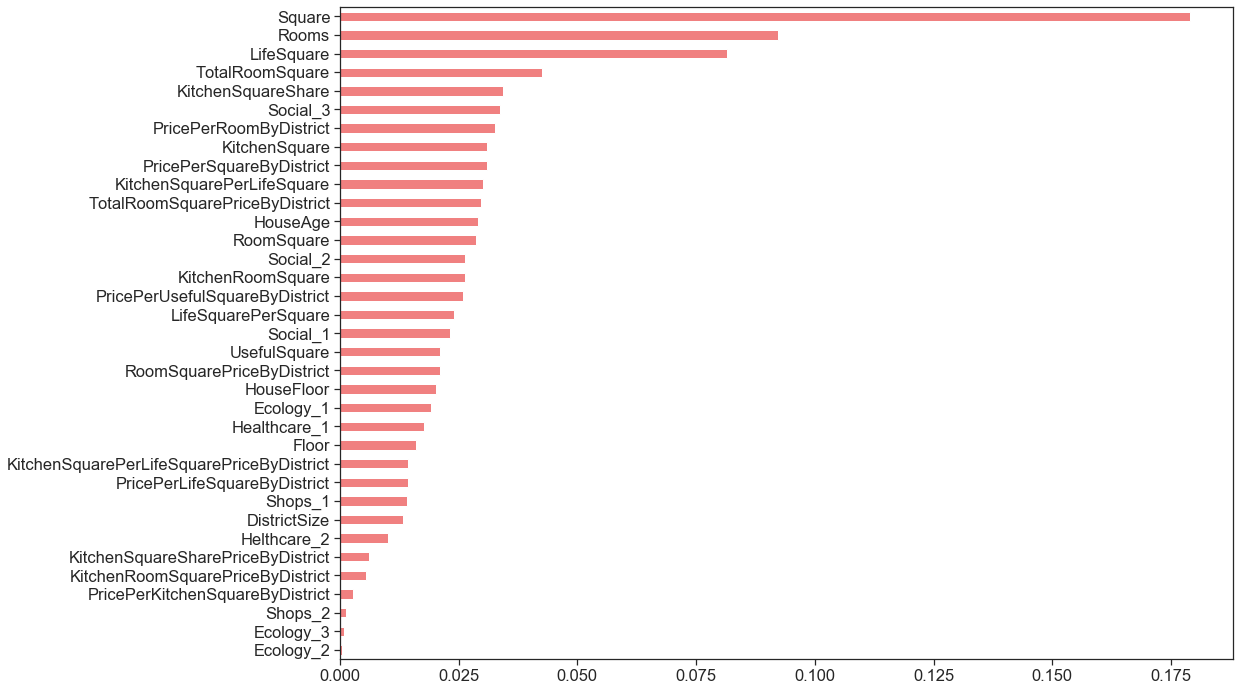

In [335]:
importances = random_model.feature_importances_
feature_imp = pd.Series(importances, index=feature_names)
feature_imp.sort_values(ascending=True, inplace=True)

feature_imp.plot(kind='barh', figsize=(16, 12), color='LightCoral');

Получили некоторые слабо значимые признаки:
    
* **Ecology_2, Ecology_3** - экологические показатели местности
* **Shops_2** - показатель, связанный с наличием магазинов, торговых центров

In [380]:
selected_names = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 #'Ecology_2',
 #'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 #'Shops_2',
 'HouseAge',
 'RoomSquare',
 'LifeSquarePerSquare',
 'KitchenSquareShare',
 'KitchenSquarePerLifeSquare',
 'UsefulSquare',
 'TotalRoomSquare',
 'KitchenRoomSquare',
 'DistrictSize',
 'PricePerRoomByDistrict',
 'PricePerSquareByDistrict',
 'KitchenSquareSharePriceByDistrict',
 'KitchenSquarePerLifeSquarePriceByDistrict',
 'PricePerLifeSquareByDistrict',
 'PricePerKitchenSquareByDistrict',
 'PricePerUsefulSquareByDistrict',
 'RoomSquarePriceByDistrict',
 'TotalRoomSquarePriceByDistrict',
 'KitchenRoomSquarePriceByDistrict']

Проведу обучение уже без этих признаков

In [382]:
final_model = VotingRegressor([('model1', gb_model), ('model2', light_model), ('model3', xgb_model), ('model4', ctb_model)])

In [383]:
evaluate_model(final_model, train_df[selected_names], train_df['Price'])

[16:17:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

Показатели действительно оказались слабо информативными, доля объяснённой дисперсии слегка возросла.

In [384]:
final_model.fit(train_df[selected_names], train_df['Price'])

[16:22:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('model1',
                             GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=7,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                               

In [386]:
y_pred = final_model.predict(test_df[selected_names])

In [387]:
combine_preds = pd.DataFrame()
combine_preds['Id'] = test_df['Id']
combine_preds['Price'] = y_pred
combine_preds.head()

,Id,Price
0,725,158262.933881
1,15856,212344.516384
2,5480,220593.293765
3,15664,359420.464059
4,14275,143810.831727


In [388]:
combine_preds.to_csv('gb_xgb_lgb_feat_lessprep', index=False)